In [1]:
import os
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

import wandb
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

## CamVid Dataset

In [2]:
path = untar_data(URLs.CAMVID)
codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = get_image_files(path/"images")

### Logging on Tables

In [3]:
def log_dataset():
    image_files = sorted(glob.glob(os.path.join(str(path), "images/*.png")))
    label_files = sorted(glob.glob(os.path.join(str(path), "labels/*.png")))
    class_labels = {k: v for k, v in enumerate(codes)}
    table_data = []
    for idx in tqdm(range(len(image_files))):
        image = np.array(Image.open(image_files[idx]))
        mask_data = np.array(Image.open(label_files[idx]))
        table_data.append([
            wandb.Image(image),
            wandb.Image(image, masks={
                "predictions": {
                    "mask_data": mask_data,
                    "class_labels": class_labels
                }
            })
        ])


    with wandb.init(project="status-report", entity="hydranet"):
        wandb.log({"CamVid Dataset": wandb.Table(
            data=table_data, columns=["Images", "Segmentation Masks"]
        )})


# Uncomment to log the CamVid Dataset as an artifact
# log_dataset()

### DataLoader for Segmentation

In [4]:
def label_func(fn):
    return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [5]:
data_loader = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames=fnames, label_func=label_func, codes=codes, 
    item_tfms=Resize((720 // 4, 960 // 4)),
)

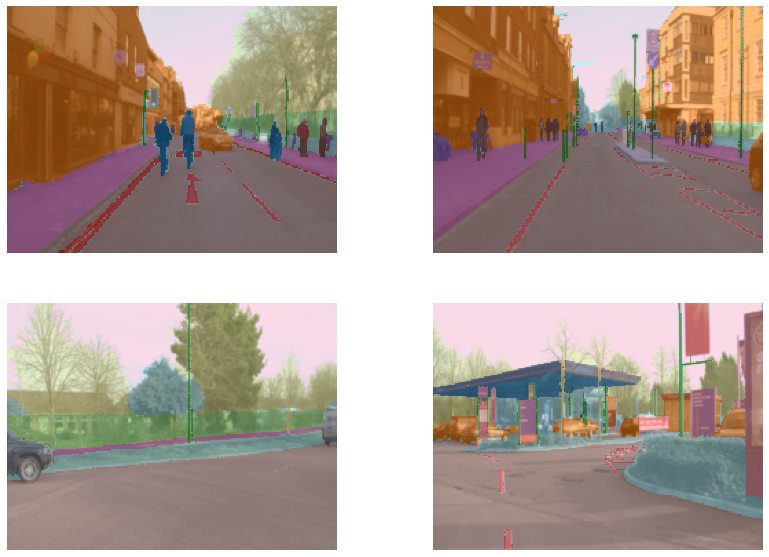

In [6]:
data_loader.show_batch(max_n=4, vmin=1, vmax=30, figsize=(14, 10))

## Semantic Segmentation Model

In [7]:
class ConvLayer(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 1,
        groups: int = 1,
        stride: int = 1,
        activation: bool = True
    ):
        layers = [
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride=stride,
                padding=kernel_size // 2,
                groups=groups,
                bias=False
            ),
            nn.BatchNorm2d(out_channels)
        ] + (
            [nn.ReLU6(inplace=True)] if activation else []
        )
        super().__init__(*layers)

In [8]:
class CRPBlock(nn.Module):
    """A bunch of convs and a maxpool with a tricky forward"""
    def __init__(self, in_channels, out_channels, num_stages=1, use_groups=False):
        super().__init__()
        groups = in_channels if use_groups else 1
        convs = [nn.Conv2d(
            in_channels if (i == 0) else out_channels,
            out_channels, kernel_size=1, bias=False, groups=groups
        ) for i in range(num_stages)]
        self.convs = nn.ModuleList(convs)
        self.pool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)

    def forward(self, x):
        "y = x + f(x) + f(f(x)) + f(f(f(x)))..."
        out = x
        for conv in self.convs:
            out = conv(self.pool(out))
            x = out + x
        return x

In [9]:
class UnetBlock(nn.Module):

    def __init__(
        self, in_up, in_side, out_channels, kernel_size=1, num_stages=4, use_groups=False
    ):
        super().__init__()
        self.conv_up   = ConvLayer(in_up, out_channels, kernel_size)
        self.conv_side = ConvLayer(in_side, out_channels, kernel_size)
        self.crp = CRPBlock(
            out_channels, out_channels, num_stages=num_stages, use_groups=use_groups
        )

    def forward(self, side_input, up_input):
        up_input = self.conv_up(up_input)
        side_input = self.conv_side(side_input)
        if up_input.shape[-2:] != side_input.shape[-2:]:
            up_input = F.interpolate(
                up_input, size=side_input.shape[-2:], mode="bilinear", align_corners=False
            )
        out = self.crp(F.relu(up_input + side_input))
        return out

In [10]:
class DynamicUnet(nn.Module):
    """
    A Unet that take almost any backbone from timm
    Reference: https://github.com/tcapelle/hydra_net/blob/master/hydranet/models.py#L13
    """
    def __init__(self, backbone="mobilenetv2_100", dim=256):
        super().__init__()
        self.encoder = timm.create_model(backbone, pretrained=True, features_only=True)
        # passing dummy tensor to get sizes
        dummy_tensor = torch.rand([1, 3, 64, 64])
        features = self.encoder(dummy_tensor)
        ch_sizes = [list(f.shape)[1] for f in features][::-1]
        self.upsample_blocks = nn.ModuleList()
        self.mid_conv = ConvLayer(ch_sizes[0], dim, 3)
        for i, ch_size in enumerate(ch_sizes[1:]):
            self.upsample_blocks.append(
                UnetBlock(
                    dim, ch_size, out_channels=dim, use_groups=(i==(len(features)-2))
                )
            )


    def forward(self, x):
        input_shape = x.shape
        # features reversed in order
        features = self.encoder(x)[::-1]
        # put last feature on dim of the model
        x = self.mid_conv(features[0])
        # upsample blocks with shortcurts from the sides
        for f, ublock in zip(features[1:], self.upsample_blocks):
            x = ublock(f, x)
        x = F.interpolate(x, size=input_shape[-2:], mode="bilinear", align_corners=False)
        return x

In [11]:
class SegmentationModel(nn.Module):
    def __init__(self, backbone="mobilenetv2_100", hidden_dim=256, num_classes=21):
        super().__init__()
        self.backbone = DynamicUnet(backbone, dim=hidden_dim)
        self.segmentation_head = nn.Sequential(
            ConvLayer(hidden_dim, hidden_dim),
            nn.Conv2d(hidden_dim, num_classes, kernel_size=1, bias=False)
        )

    def forward(self, x):
        backbone_out = self.backbone(x)
        return self.segmentation_head(backbone_out)

## Training

In [12]:
run = wandb.init(project="status-report", entity="hydranet")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: geekyrakshit (use `wandb login --relogin` to force relogin)


In [13]:
segmentation_model = SegmentationModel(num_classes=len(codes))

In [15]:
save_model_callback = SaveModelCallback(fname="unet_mobilenetv2_100")
mixed_precision_callback = MixedPrecision()
wandb_callback = WandbCallback(log_preds=False)


learner = Learner(
    data_loader,
    segmentation_model,
    loss_func=CrossEntropyLossFlat(axis=1),
    metrics=[DiceMulti(), foreground_acc],
    cbs=[save_model_callback, mixed_precision_callback, wandb_callback]
)

SuggestedLRs(valley=0.0003981071640737355)

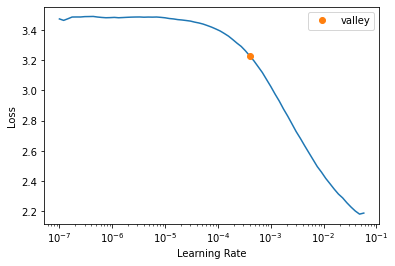

In [16]:
learner.lr_find()

In [17]:
learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,1.845573,1.017659,0.142845,0.755331,00:14
1,0.959134,1.162107,0.186705,0.702538,00:13
2,0.651374,0.520885,0.341724,0.849995,00:13
3,0.498849,0.485682,0.368713,0.856415,00:14
4,0.412987,0.436135,0.410729,0.866409,00:13
5,0.355319,0.523052,0.412278,0.842738,00:14
6,0.310931,0.356301,0.479413,0.888028,00:14
7,0.279961,0.321547,0.493574,0.897475,00:14
8,0.260842,0.312626,0.500207,0.900422,00:13
9,0.250206,0.309921,0.504644,0.900960,00:13


Better model found at epoch 0 with valid_loss value: 1.0176591873168945.
Better model found at epoch 2 with valid_loss value: 0.520885169506073.
Better model found at epoch 3 with valid_loss value: 0.48568230867385864.
Better model found at epoch 4 with valid_loss value: 0.4361354112625122.
Better model found at epoch 6 with valid_loss value: 0.35630083084106445.
Better model found at epoch 7 with valid_loss value: 0.3215472102165222.
Better model found at epoch 8 with valid_loss value: 0.31262561678886414.
Better model found at epoch 9 with valid_loss value: 0.30992063879966736.
